In [1]:
# Import everything! 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import time
import argopy
import gsw

Importing data...
Time to create DataFetcher variable :  0.01393580436706543
Time to get data from DataFetcher :  10.214613914489746
[0.0000e+00 1.1000e+00 2.5000e+00 ... 1.9377e+03 1.9631e+03 1.9882e+03]


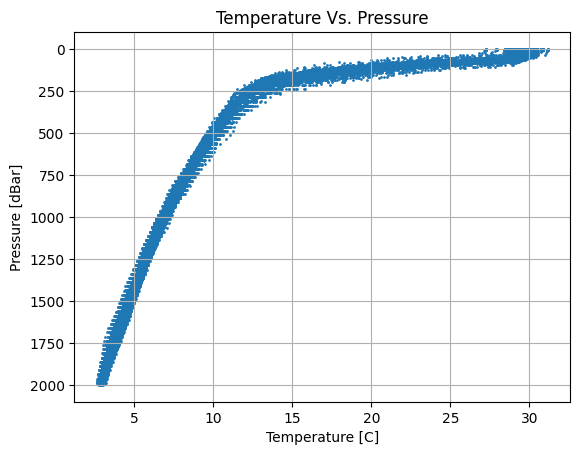

True

In [ ]:
# Gabe's code to get data, save in csv, and plot temp
def plot_temp_vs_depth():
    try:
        df_raw = pd.read_csv('data.csv')
    except:
        print("Importing data...")
        t0 = time.time()
        lat_range = [5, 20]     # Latitude: 5°N to 20°N
        lon_range = [80, 95]   # Longitude: 80°E to 95°E
        # ArgoSet = argopy.DataFetcher().region([80, 95, 5, 20, 0, 2000, '2023-12', '2024-03'])
        ArgoSet = argopy.DataFetcher().region([lon_range[0], lon_range[1], lat_range[0], lat_range[1], 0, 2000, '2024-06', '2024-09']) # Bay of Bengal
        print("Time to create DataFetcher variable : ", time.time() - t0)
        df_raw = ArgoSet.data.argo.point2profile().to_dataframe()
        print("Time to get data from DataFetcher : ", time.time() - t0)
        # df_raw.to_csv('data_summer.csv') # Uncomment if you want to save the file

    # Remove rows where temp is None
    df = df_raw.dropna(subset=['TEMP', 'PRES'])

    # Define the variables to work with:
    temp = np.array(df['TEMP'])
    pressure = np.array(df['PRES'])
    print(pressure)

    # Scatter data and add grid
    plt.scatter(temp, pressure, s=1)
    plt.grid(True)
    plt.gca().invert_yaxis()

    # Adding labels to the axes and title
    plt.xlabel('Temperature [C]')
    plt.ylabel('Pressure [dBar]')
    plt.title('Temperature Vs. Pressure')

    # plt.savefig('figures/temp_vs_depth.png')
    plt.show()

    return True

plot_temp_vs_depth()

In [25]:
def load_csv():
    # Load the data from the CSV file
    data = pd.read_csv('/Users/emilywong/Documents/Processing/sioc210_data_project/data_winter.csv')

    # Show the first few rows of the data to confirm it's loaded correctly
    print(data.head())
    return data

def filter_one_float(data):
    # Filter data for one specific float (e.g., PLATFORM_NUMBER 2902766)
    float_data = data[data['PLATFORM_NUMBER'] == 2902766]

    # Sort by pressure (depth) if needed
    float_data = float_data.sort_values(by='PRES')

    print(float_data.head())
    return float_data

In [ ]:
# Calculate the means and stds of salinity, density (by first calculating density), and temp 
def calculate_mean_profiles(data):
    # Create arrays to store averaged values
    mean_salinity = []
    mean_density = []
    mean_temperature = []
    std_salinity = []
    std_density = []
    std_temperature = []
    filtered_depths = [] # To get rid of weird line

    """
    # filter data by QC :
    for index, row in data.iterrows() :
        if row['PSAL_QC'] > 1 or row['TEMP_QC'] > 1 or row['PRES_QC'] > 1 :
            data.drop(index, inplace=True) # removes row
    """
    
    # Group data by depth to ensure unique depth entries
    # Seems too work better than looking at unique values 
    grouped_data = data.groupby('PRES')

    # Loop over each unique depth in the grouped data
    for depth, depth_data in grouped_data:
        # Skip if depth_data is empty
        if depth_data.empty:
            # Append NaN values for missing data
            mean_salinity.append(np.nan)
            std_salinity.append(np.nan)
            mean_temperature.append(np.nan)
            std_temperature.append(np.nan)
            mean_density.append(np.nan)
            std_density.append(np.nan)
            filtered_depths.append(depth)
            continue

        # Salinity calculations
        mean_salinity.append(depth_data['PSAL'].mean())
        std_salinity.append(depth_data['PSAL'].std())
        
        # Temperature calculations
        mean_temperature.append(depth_data['TEMP'].mean())
        std_temperature.append(depth_data['TEMP'].std())
        
        # Density calculations (using gsw for in-situ density; should we be using potential instead?)
        # Uses same method as calculate_density function
        salinity = depth_data['PSAL'].values
        temperature = depth_data['TEMP'].values
        pressure = depth
        latitude = depth_data['LATITUDE'].iloc[0]  
        longitude = depth_data['LONGITUDE'].iloc[0]
        
        SA = gsw.SA_from_SP(salinity, pressure, longitude, latitude)
        CT = gsw.CT_from_t(SA, temperature, pressure)
        density = gsw.rho(SA, CT, pressure)
        
        mean_density.append(np.mean(density))
        std_density.append(np.std(density))
        
        # Append only unique depths
        filtered_depths.append(depth)

    return filtered_depths, mean_salinity, std_salinity, mean_temperature, std_temperature, mean_density, std_density

In [5]:
def calculate_density(float_data):
    # Calculate in-situ density using gsw 
    # Modifies the input dataframe directly by creating a new column 'DENSITY'

    # Sort by pressure (depth)
    float_data = float_data.sort_values(by='PRES')

    # Calculate Absolute Salinity (SA) and Conservative Temperature (CT)
    # Note: gsw expects salinity in Practical Salinity Units (PSU), temperature in degrees Celsius, and pressure in decibars.
    pressure = float_data['PRES'].values
    salinity = float_data['PSAL'].values
    temperature = float_data['TEMP'].values
    latitude = float_data['LATITUDE'].values[0]  # Assuming constant latitude for the float
    longitude = float_data['LONGITUDE'].values[0]  # Assuming constant longitude for the float

    # Calculate Absolute Salinity and Conservative Temperature
    SA = gsw.SA_from_SP(salinity, pressure, longitude, latitude)
    CT = gsw.CT_from_t(SA, temperature, pressure)

    # Calculate density (in-situ density) using the equation of state
    density = gsw.rho(SA, CT, pressure)

    return pressure, density


In [9]:
def create_single_plot(float_data, x_column, x_label, title):
    """
    General function to create a plot for a single float's data.

    Parameters:
    - float_data: DataFrame containing the data for a single float.
    - x_column: str, column name for the x-axis data (e.g., 'PSAL' for salinity, 'TEMP' for temperature).
    - x_label: str, label for the x-axis.
    - title: str, title for the plot.
    - color: str, color of the plot line.
    """
    # Determine y-axis (depth) and x-axis data
    y_data = float_data['PRES']
    x_data = float_data[x_column]

    # Plot data vs. Depth
    plt.figure(figsize=(8, 6))
    plt.plot(x_data, y_data, label=x_label)

    # Invert the y-axis so that the surface is at the top
    plt.gca().invert_yaxis()

    # Label the axes
    plt.xlabel(x_label)
    plt.ylabel('Pressure [dbar]')

    # Add a title
    plt.title(title)

    # Show the plot
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_avg_profile(unique_depths, mean_values, std_values, x_label, title, x_range=None):
    """
    General function to plot the average profile with standard deviation shading.

    Parameters:
    - unique_depths: list or array of depth values (y-axis).
    - mean_values: list or array of mean values for the variable (x-axis).
    - std_values: list or array of standard deviation values for the variable.
    - x_label: str, label for the x-axis (e.g., 'Salinity [PSU]', 'Temperature [C]', 'Density [kg/m^3]').
    - title: str, title for the plot.
    - x_range: tuple, optional, range for the x-axis (e.g., (31, 36) for salinity).
    """
    plt.figure(figsize=(8, 6))
    plt.plot(mean_values, unique_depths, label=f'Mean {x_label}')
    plt.fill_betweenx(unique_depths, 
                      np.array(mean_values) - np.array(std_values), 
                      np.array(mean_values) + np.array(std_values), 
                      color='b', alpha=0.2, label=f'{x_label} Std Dev')
    
    plt.gca().invert_yaxis()  # Invert y-axis to show surface at the top
    if x_range:
        plt.xlim(x_range)
    plt.xlabel(x_label)
    plt.ylabel('Pressure [dbar]')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_scatter_all(data, x_column, y_column, x_label, title, alpha=0.1, point_size=5, x_range=None):
    """
    General function to plot all data points with transparency for clustering visibility.

    Parameters:
    - data: pandas DataFrame containing the dataset.
    - x_column: str, name of the column to plot on the x-axis (e.g., 'PSAL' for salinity).
    - y_column: str, name of the column to plot on the y-axis (e.g., 'PRES' for pressure).
    - x_label: str, label for the x-axis.
    - title: str, title for the plot.
    - alpha: float, transparency level for points (0 to 1).
    - point_size: int, size of each point in the scatter plot.
    - x_range: tuple, optional, range for the x-axis (e.g., (31, 36) for salinity).
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(data[x_column], data[y_column], alpha=alpha, edgecolor='none', s=point_size)

    plt.gca().invert_yaxis()
    if x_range:
        plt.xlim(x_range)
    plt.xlabel(x_label)
    plt.ylabel('Pressure [dbar]')
    plt.title(title)
    plt.grid(True)
    plt.show()

   N_PROF  N_LEVELS  CYCLE_NUMBER DATA_MODE DIRECTION  PLATFORM_NUMBER  \
0      63         0           108         D         A          2902769   
1      63         1           108         D         A          2902769   
2      63         2           108         D         A          2902769   
3      63         3           108         D         A          2902769   
4      63         4           108         D         A          2902769   

   POSITION_QC  PRES  PRES_ERROR  PRES_QC      PSAL  PSAL_ERROR  PSAL_QC  \
0            1   0.3         2.4        1  33.91282        0.01        1   
1            1   1.0         2.4        1  33.91206        0.01        1   
2            1   2.0         2.4        1  33.91101        0.01        1   
3            1   2.9         2.4        1  33.91305        0.01        1   
4            1   3.9         2.4        1  33.91198        0.01        1   

     TEMP  TEMP_ERROR  TEMP_QC  TIME_QC  LATITUDE  LONGITUDE  \
0  28.241       0.002        1    

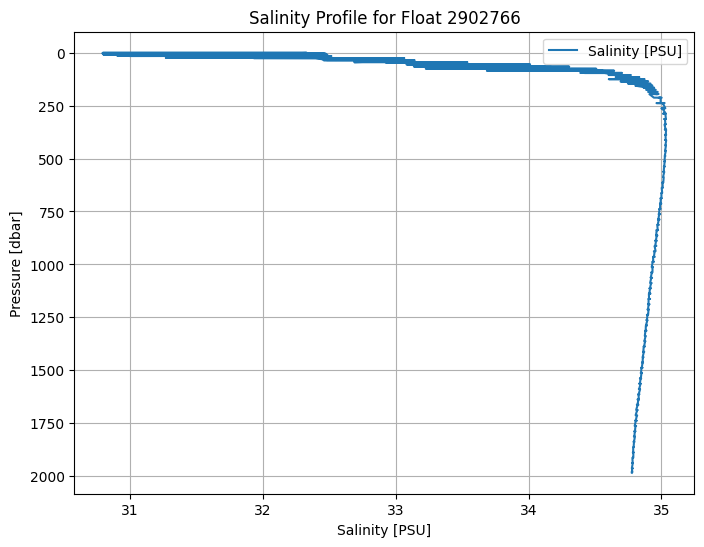

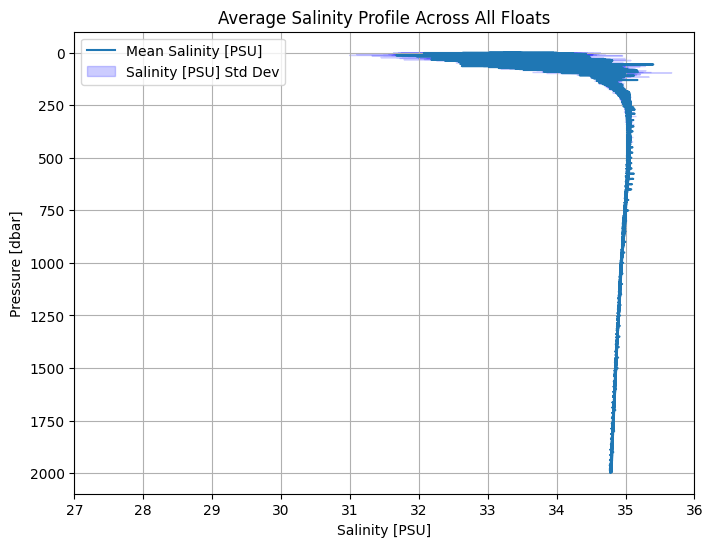

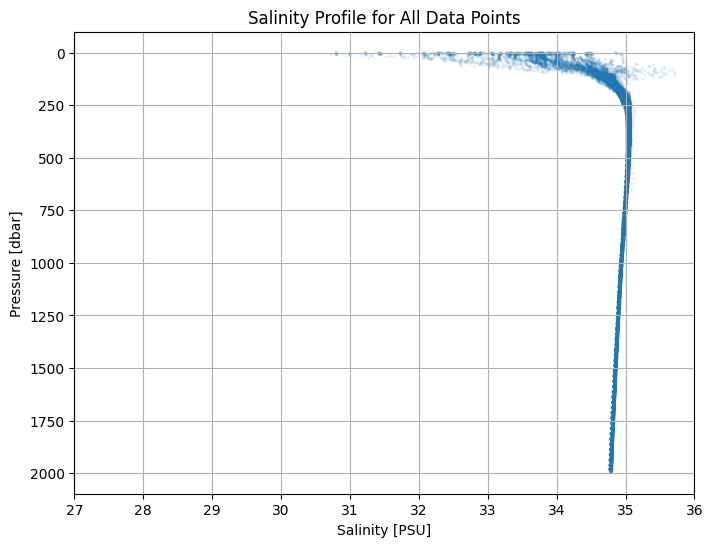

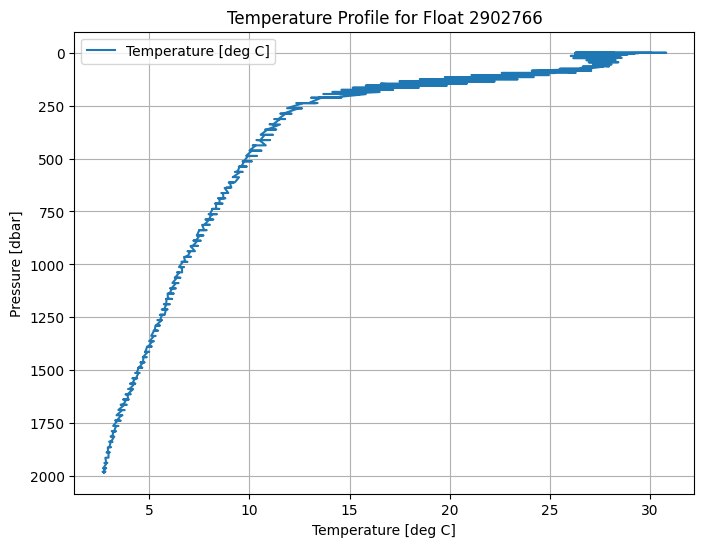

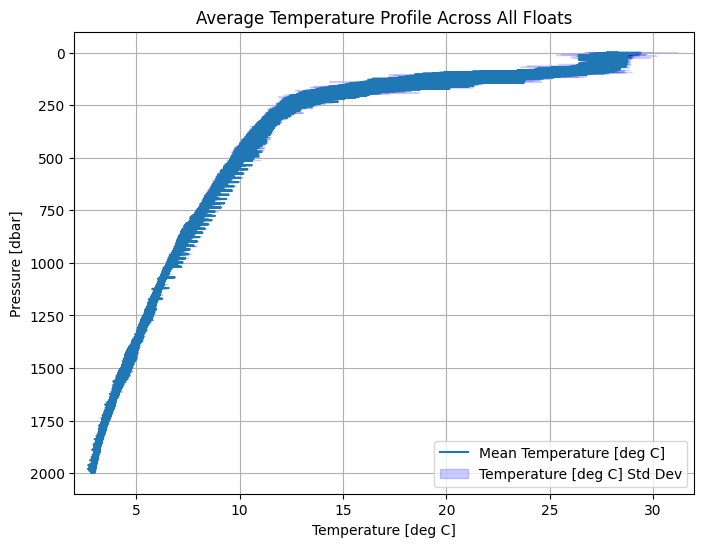

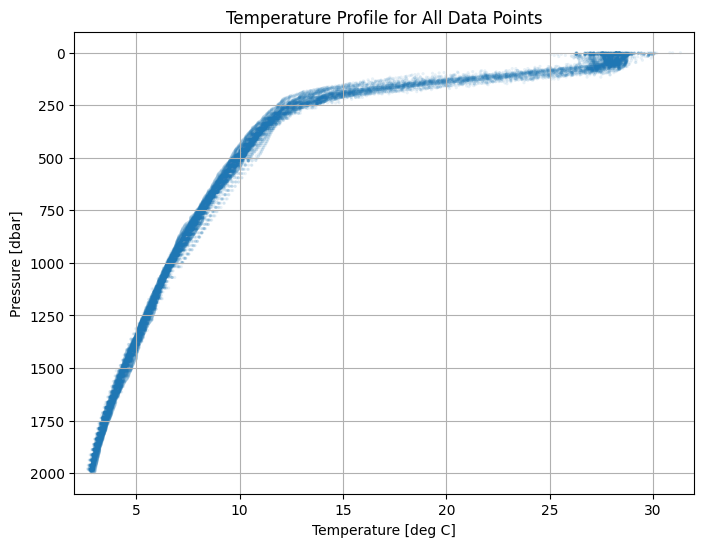

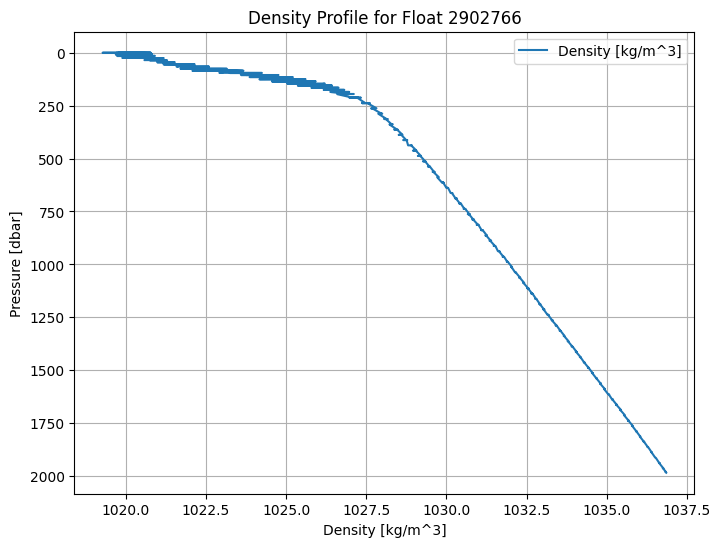

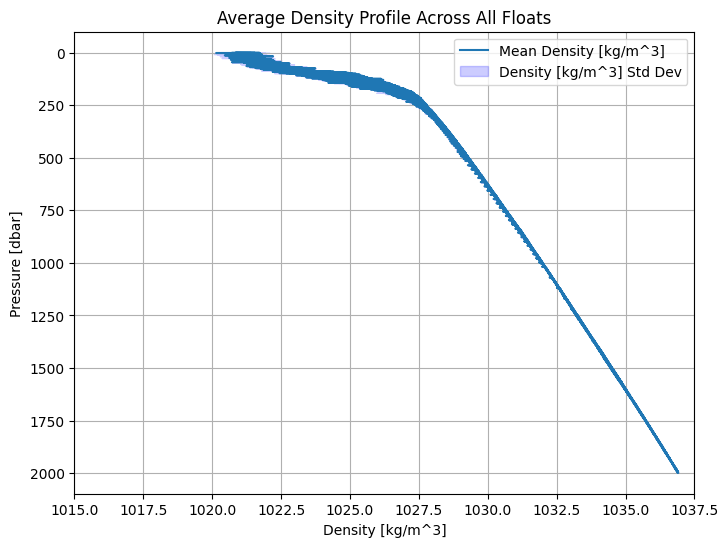

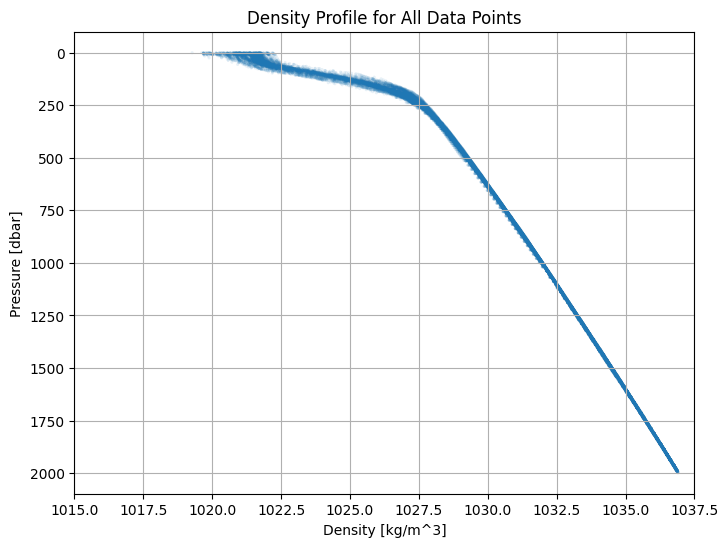

In [26]:
# Main function 

all_data = load_csv()

# filter data by QC :
for index, row in all_data.iterrows() :
    if row['PSAL_QC'] > 1 or row['TEMP_QC'] > 1 or row['PRES_QC'] > 1 :
        all_data.drop(index, inplace=True) # removes row

print("Number of profiles in data:", all_data['N_PROF'].nunique())

one_float_data = filter_one_float(all_data)

unique_depths, mean_salinity, std_salinity, mean_temperature, std_temperature, mean_density, std_density = calculate_mean_profiles(all_data)

# Calculate density values
one_pressure_value, one_density_value = calculate_density(one_float_data)
pressure_values, density_values = calculate_density(all_data)

# Salinity plots
create_single_plot(one_float_data, x_column='PSAL', x_label='Salinity [PSU]', title='Salinity Profile for Float 2902766')
plot_avg_profile(unique_depths, mean_salinity, std_salinity, x_label='Salinity [PSU]', title='Average Salinity Profile Across All Floats', x_range=(27, 36))
plot_scatter_all(all_data, x_column='PSAL', y_column='PRES', x_label='Salinity [PSU]', title='Salinity Profile for All Data Points', x_range=(27, 36))

# Temperature plots
create_single_plot(one_float_data, x_column='TEMP', x_label='Temperature [deg C]', title='Temperature Profile for Float 2902766')
plot_avg_profile(unique_depths, mean_temperature, std_temperature, x_label='Temperature [deg C]', title='Average Temperature Profile Across All Floats', x_range=(2, 32))
plot_scatter_all(all_data, x_column='TEMP', y_column='PRES', x_label='Temperature [deg C]', title='Temperature Profile for All Data Points', x_range=(2, 32))

# Density plots
create_single_plot(pd.DataFrame({'DENSITY': one_density_value, 'PRES': one_pressure_value}), x_column='DENSITY', x_label='Density [kg/m^3]', title='Density Profile for Float 2902766')
plot_avg_profile(unique_depths, mean_density, std_density, x_label='Density [kg/m^3]', title='Average Density Profile Across All Floats', x_range=(1015, 1037.5))
plot_scatter_all(pd.DataFrame({'DENSITY': density_values, 'PRES': pressure_values}), x_column='DENSITY', y_column='PRES', x_label='Density [kg/m^3]', title='Density Profile for All Data Points', x_range=(1015, 1037.5))

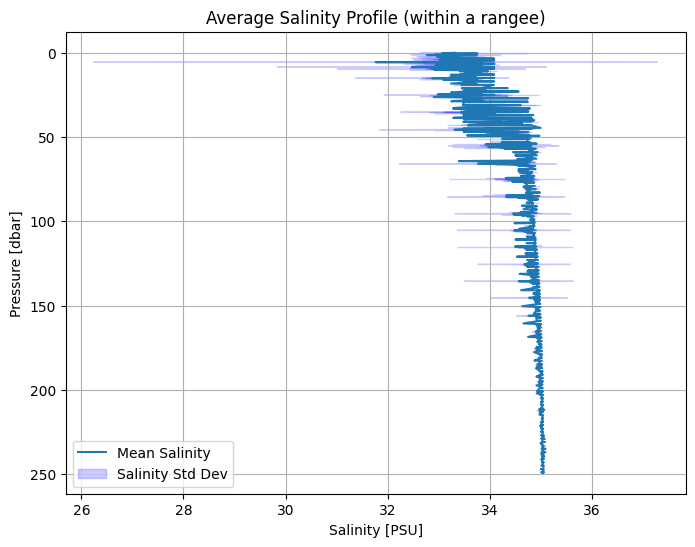

In [7]:
# Plot only a subsection of the larger plot

# Define the depth range 
min_depth = 0
max_depth = 250

# Filter the data for depths within the specified range
filtered_depths_range = [depth for depth in unique_depths if min_depth <= depth <= max_depth]
mean_salinity_range = [mean_salinity[i] for i, depth in enumerate(unique_depths) if min_depth <= depth <= max_depth]
std_salinity_range = [std_salinity[i] for i, depth in enumerate(unique_depths) if min_depth <= depth <= max_depth]

plt.figure(figsize=(8, 6))
plt.plot(mean_salinity_range, filtered_depths_range, label='Mean Salinity')
plt.fill_betweenx(filtered_depths_range,
                  [m - s for m, s in zip(mean_salinity_range, std_salinity_range)],
                  [m + s for m, s in zip(mean_salinity_range, std_salinity_range)],
                  color='b', alpha=0.2, label='Salinity Std Dev')

plt.gca().invert_yaxis()
plt.xlabel('Salinity [PSU]')
plt.ylabel('Pressure [dbar]')
plt.title('Average Salinity Profile (within a rangee)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(1, figsize=(10, 6))
plt.figure(2, figsize=(10, 6))

for select in [0, 1, 2, 3] : # 0=fall, 1=winter, 2=spring, 3=summer
    season=seasons[select]
    filename=filenames[select] 
    date=dates[select] 
    filepath = os.getcwd() + '/' + filename #changing filepath separator for Mac from \\ to /
    all_data = load_csv(filepath)
    # data = filter_one_float(all_data) # Work with one float
    data=all_data # Or work with all floats
    print(data['TIME'].head())
    print(data['TIME'].tail()) #check we have the right season

    # define pressure bins
    max_pressure = data['PRES'].max()
    print('Max pressure over the selected period is '+str(max_pressure)+' dbar')
    pressure_bins = np.concatenate((np.arange(0, 10, 2),
                                    np.arange(10, 100 , 10), 
                                    np.arange(100, max_pressure + 25, 25)))

    #assign each row to a pressure bin
    data['PRES_BIN'] = pd.cut(data['PRES'], bins=pressure_bins, labels=pressure_bins[:-1])

    #average inside each bin
    data=data.groupby('PRES_BIN', observed=True).agg(
        avg_temp=('TEMP', 'mean'),
        avg_salinity=('PSAL', 'mean')
    ).reset_index()

    plt.figure(1)
    plt.plot(data['avg_temp'], data['PRES_BIN'], label=season)

    plt.figure(2)
    plt.plot(data['avg_salinity'], data['PRES_BIN'], label=season)

plt.figure(1)
plt.gca().invert_yaxis()  # Invert the y-axis so the surface is at the top
plt.xlabel('Temperature [°C]')
plt.ylabel('Pressure Bin')
plt.title('Binned Temperature')
plt.ylim(1000,0)
plt.legend()

plt.figure(2)
plt.gca().invert_yaxis()  # Invert the y-axis so the surface is at the top
plt.xlabel('Salinity [PSU]')
plt.ylabel('Pressure Bin')
plt.title('Binned Salinity')
plt.ylim(1000,0)
plt.legend()
    
# Display the plot
plt.draw()

# uncomment lines below to plot only surface
plt.figure(1)
plt.ylim(200,0)
plt.figure(2)
plt.ylim(200,0)
plt.draw()

In [ ]:
# Plot T hovmoller diagram 
hovmoller_data = resampled_data.pivot(index='PRES_BIN', columns='TIME', values='avg_temp') # Pivot the data to have TIME on the columns and PRES_BIN on the rows
hovmoller_data.columns = pd.to_datetime(hovmoller_data.columns)

plt.figure(figsize=(7, 4))
plt.pcolormesh(hovmoller_data.columns, hovmoller_data.index, hovmoller_data.values, shading='auto', cmap='coolwarm')

for date in hovmoller_data.columns:
    if date.month == 1:
        plt.axvline(x=date, color='k', linestyle='--', linewidth=0.5)  # Add dashed vertical line

plt.colorbar(label='Temperature (°C)')
plt.gca().invert_yaxis()  # Invert y-axis to have surface at the top
plt.xlabel('Time (Months)')
plt.ylabel('Pressure Bin (dbar)')
plt.title('Hovmöller Diagram: Temperature Averaged Monthly Across All Floats')
plt.xticks(rotation=90)
january_dates = [date for date in hovmoller_data.columns if date.month == 1]
plt.xticks(ticks=january_dates, labels=[date.strftime('%b-%Y') for date in january_dates], rotation=90)
plt.ylim(160,0)

plt.show()